In [1]:
from notebook_log_loading import load_sensor_log_file

sensor_log,first_timestamp=load_sensor_log_file("../to_study/initial_motion_calibration_3.txt")

In [5]:
import sys, os
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii","underpinnings")))
from collections import deque
from gyrii.Gyrus import ThreadedGyrus
from gyrii.underpinnings.NNCalibration2 import StatePredictorWithPolicy
import numpy as np
import torch
import torch.nn as nn


def toeuler(q):
    w=q[3]
    i=q[0]
    j=q[1]
    k=q[2]
    s=1
    
    cpch=1-2*s*(j*j+k*k)
    cpsh=2*s*(i*j+k*w)
    sp=2*s*(i*k-j*w)
    sbcp=2*s*(j*k+i*w)    
    cbcp=1-2*s*(i*i+j*j)
    
    conv=1
    #conv=360/(2*np.pi)
    #heading=360*np.arctan2(cpsh,cpch)/(2*3.14)
    #pitch=-360*np.arcsin(sp)/(2*3.14)
    #bank=360*np.arctan2(sbcp,cbcp)/(2*3.15)
    heading=conv*np.arctan2( 2*(w*i+j*k),1-2*(i*i+j*j))
    pitch=conv*np.arcsin(np.clip(2*(w*j-k*i),-1,1))    
    bank=conv*np.arctan2( 2*(w*k+i*j),1-2*(j*j+k*k))
    return [heading,pitch,bank]

def get_unique_tagged_objects(tagged_objects,objects_to_watch):
        ret={}
        label_list=[ x["label"] for x in tagged_objects]
        for key in objects_to_watch:
            if label_list.count(key)>1 or label_list.count(key)==0:
                continue
            elem=next(filter(lambda x: x["label"]==key,tagged_objects))
            ret[key]=elem
        return ret

class VisualMotionCalibGyrus(ThreadedGyrus):
    def __init__(self,broker,load_file=None):

        self.motionpredictor=nn.Sequential(nn.Linear(4,4),
                              nn.Tanh(),
                              nn.Linear(4,2))

        self.policy=nn.Sequential(nn.Linear(4,4),
                                  nn.Tanh(),
                                  nn.Linear(4,2),
                                  nn.Tanh())
        self.max_recent_history=20

        self.gyros=deque([],maxlen=self.max_recent_history)
        self.accels=deque([],maxlen=self.max_recent_history)
        self.headings=deque([],maxlen=self.max_recent_history)
        #self.last_gyro=np.zeros(3) #last gyroscope reading
        #self.last_accel=np.zeros(3) #last accelerometer reading
        self.last_image_timestamp=0
        self.next_motor_end_time=0                
        
        self.last_unique_objects={}
        self.last_heading=0
        self.last_frame_motion_command=[0,0]
        
        #for debug
        self.all_delta_headings=[]
        self.all_delta_angles=[]
        self.all_delta_dists=[]
        self.all_motion_vectors=[]
        self.all_gyros=[]
        self.all_gyros_timestamp=[]
        self.still_timestamp=[]
        self.still_or_not=[]
        self.motor1_image_timestamp=[]
        self.motor1_value=[]
        
    def get_keys(self):
        return []
    
    def get_name(self):
        return "VisualMotionCalibGyrus"
    
    def holding_still(self,timestamp): #return true if I think I'm holding still
        if len(self.gyros)==0:
            return False
        gyros,accels,heading=self.get_closest_kinematics(timestamp)
        if np.linalg.norm(gyros)>0.03:
            return False
        if np.linalg.norm(accels)>0.15:
            return False
        return True
    

    
    def get_closest_value(self,timestamp,mylist):
        #for mylist ordered by [time,value], return the value that is closest to the input timestamp
        if len(mylist)==0:
            return None
        if timestamp<=mylist[0][0]:
            return mylist[0][1]
        
        first_val=mylist[0]
        second_val=None
        for val in mylist:
            if timestamp>val[0]:
                second_val=val
            else:
                first_val=val
        if abs(first_val[0]-timestamp)<abs(second_val[0]-timestamp):
            return first_val[1]
        else:
            return second_val[1]
    
    def get_closest_kinematics(self,timestamp):
        return self.get_closest_value(timestamp,self.gyros),self.get_closest_value(timestamp,self.accels),self.get_closest_value(timestamp,self.headings)

        
    def read_message(self,message):
        if 'packets' in message: #rotation etc
            for packet in message['packets']:
                self.gyros.append( [packet["gyroscope_timestamp"],packet["gyroscope"]])
                self.accels.append( [packet["acceleration_timestamp"],packet["acceleration"]])
                euler_angles=toeuler(packet["rotation_vector"])
                self.headings.append( [packet["rotation_vector_timestamp"],[euler_angles[2]]])
                
                self.all_gyros_timestamp.append(packet["gyroscope_timestamp"])
                self.all_gyros.append(np.linalg.norm(packet["gyroscope"]))
        if 'motor_command' in message:
            m=message["motor_command"]
            left_throttle=m["left_throttle"]
            right_throttle=m["right_throttle"]
            left_duration=m["left_duration"]
            right_duration=m["right_duration"]
            self.last_frame_motion_command=[left_throttle*left_duration,right_throttle*right_duration]
            self.next_motor_end_time=self.last_image_timestamp+max(left_duration,right_duration)
            
            
        if 'detections' in message:
            timestamp=message["image_timestamp"]      
            self.still_timestamp.append(timestamp)
            if not self.holding_still(timestamp): #only log when holding still
                self.still_or_not.append(0)
            else:
                self.still_or_not.append(1)
            self.motor1_image_timestamp.append(timestamp)
            self.motor1_value.append(self.last_frame_motion_command[0])
                
            
            
            
            if not self.holding_still(timestamp): #only log when holding still
                return
            if timestamp<self.next_motor_end_time:
                return
            
                        
            dets=get_unique_tagged_objects(message["detections"],[32,11])
            #use the IMU to figure out if I turend as well
            current_heading=self.get_closest_value(timestamp,self.headings)[0]
            delta_heading_imu=current_heading-self.last_heading
            for key in dets:                
                if key in self.last_unique_objects:                   
                    #exists in both this and last set
                    #TODO put cuts on bounding boxes!
                    
                    #figure out change my heading and how far I went
                    prev_loc=self.last_unique_objects[key]["spatial_array"]
                    this_loc=dets[key]["spatial_array"]
                    prev_angle=np.arctan2(prev_loc[0],prev_loc[2])
                    this_angle=np.arctan2(this_loc[0],this_loc[2])
                    delta_angle=prev_angle-this_angle #my change in heading
                    prev_xy=np.array( [prev_loc[0],prev_loc[2]])
                    this_xy=np.array( [this_loc[0],this_loc[2]])
                    #this_xy_unrotated=np.array( [ [np.cos(delta_angle),-np.sin(delta_angle)],[np.sin(delta_angle),np.cos(delta_angle)]]).dot(this_xy)
                    prevh=self.last_unique_objects[key]["bbox_array"][3]-self.last_unique_objects[key]["bbox_array"][2]
                    thish=dets[key]["bbox_array"][3]-dets[key]["bbox_array"][2]
                    deltahoverh=(thish-prevh)/(0.5*(thish+prevh))
                    dist=0.5*(np.linalg.norm(this_xy)+np.linalg.norm(prev_xy))
                    delta_dist=deltahoverh*dist
                                                            
                    #np.linalg.norm(prev_xy-this_xy) #my driving distance                                                            
                    
                    #HERE
                    self.all_motion_vectors.append(self.last_frame_motion_command)
                    self.all_delta_headings.append(delta_heading_imu)
                    self.all_delta_angles.append(delta_angle)
                    self.all_delta_dists.append(delta_dist)
                    decision_vector=[]
                    input_vector=[]
                    output_vector=[]                    
            self.last_unique_objects=dets
            self.last_heading=current_heading      
            self.last_frame_motion_command=[0,0] #assuming I got the last one
            self.last_image_timestamp=timestamp
            




In [6]:

gyrus=VisualMotionCalibGyrus(None)
for message in sensor_log:
    gyrus.read_message(message)

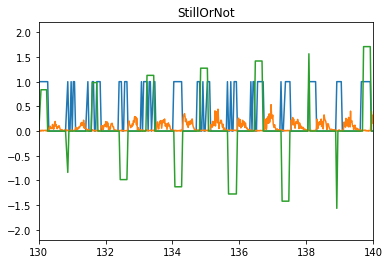

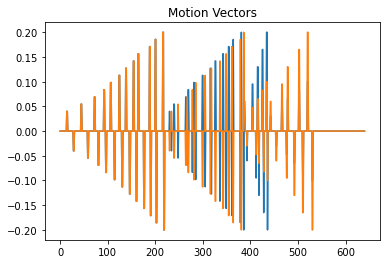

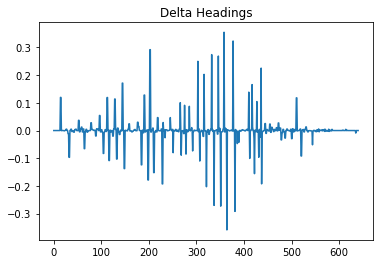

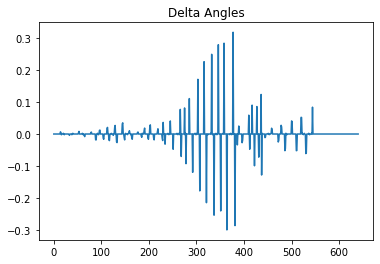

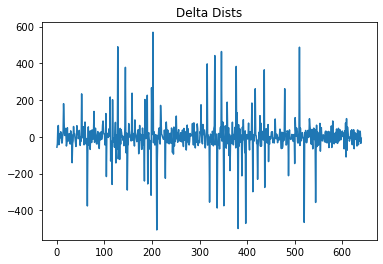

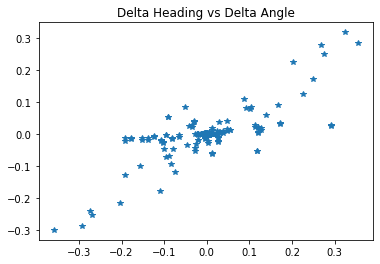

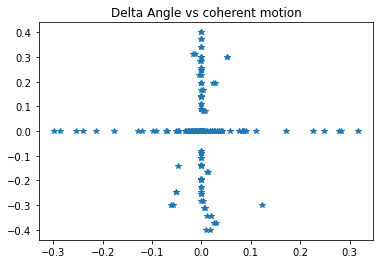

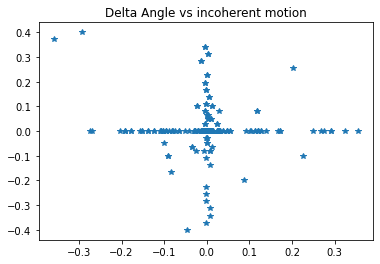

In [7]:
from matplotlib import pyplot as plt

def plotall(gyrus):
    all_motion_vectors=np.array(gyrus.all_motion_vectors)
    all_delta_headings=np.array(gyrus.all_delta_headings)
    all_delta_angles=np.array(gyrus.all_delta_angles)
    all_delta_dists=np.array(gyrus.all_delta_dists)
    
    fig, ax = plt.subplots()
    plt.title("StillOrNot")
    plt.xlim(130,140)
    plt.plot(gyrus.still_timestamp,gyrus.still_or_not)
    plt.plot(gyrus.all_gyros_timestamp,gyrus.all_gyros)
    plt.plot(gyrus.motor1_image_timestamp,10*np.array(gyrus.motor1_value))
    plt.show()
    
    
    fig, ax = plt.subplots()
    plt.title("Motion Vectors")
    plt.plot(all_motion_vectors)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Delta Headings")
    plt.plot(all_delta_headings)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Delta Angles")
    plt.plot(all_delta_angles)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Delta Dists")
    plt.plot(all_delta_dists)
    plt.show()

    fig, ax = plt.subplots()
    plt.title("Delta Heading vs Delta Angle")
    plt.plot(all_delta_headings,all_delta_angles,'*')
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Delta Angle vs coherent motion")
    plt.plot(all_delta_angles,all_motion_vectors[:,0]+all_motion_vectors[:,1],'*')
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("Delta Angle vs incoherent motion")
    plt.plot(all_delta_headings,all_motion_vectors[:,0]-all_motion_vectors[:,1],'*')
    plt.show()
    
    
    
plotall(gyrus)